# Fig.6 Properties of prediction methods

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
sns.set_style()
import pandas as pd


In [2]:
sys.path.append(os.path.join(os.getcwd(),'../repos/dysts/'))

In [3]:
sys.path.append(os.path.join(os.getcwd(),'../repos/darts/'))

In [4]:
import darts

In [5]:
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

loaded!


In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Forecasting Benchmark Results

In [7]:
import os
import json

GRANULARITY = 100
DATE = 221025 # noise level 0.8, not including RBF
#DATE = 220812 # noise level 0.2, not including RBF

#/results/221025_results_test_univariate__pts_per_period_ # large noise 
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

#220315_results_test_univariate__pts_per_period_ #Initial try
#220326_results_test_univariate__pts_per_period_
#/results/220426_results_test_univariate__pts_per_period_

with open(
    os.getcwd()
    + "/../repos/dysts/benchmarks/results/" + str(DATE) + "_results_test_univariate__pts_per_period_" + str(GRANULARITY) 
    + "__periods_12_noise.json",
    "r",
) as file:
    all_results = json.load(file)

#220428
# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)



## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue            
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)

# HS Remove unimportant methods
for equation_name in all_results:
    for model_name in ['FFT', 'FourTheta', 'AutoARIMA', 'LSS_Takens']:
        #all_results[equation_name].pop(model_name, None)
        del all_results[equation_name][model_name]

# HS using local darts
#sys.path.append(os.path.join(os.getcwd(),'../../darts/'))
import darts
from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

if GRANULARITY == 15:
    hist_values_low = hist_values.copy()
elif GRANULARITY == 100:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")
    

    #/results/221025_results_test_univariate__pts_per_period_
#/results/220812_results_test_univariate__pts_per_period_ # small noise 

if DATE == 220812:
    hist_values_low = hist_values.copy()
elif DATE == 221025:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")


all_metric_names = list(all_results_transposed["ARIMA"]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

In [8]:
df_metrics.shape

(1792, 8)

### Load mathematical properties

In [9]:
import dysts.flows

max_lyap = list()
best_scores = list()
for equation_name in all_results:    
    all_scores_per_equation = list()
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_scores_per_equation.append(all_results[equation_name][model_name]["smape"])
    
    best_scores.append(min(all_scores_per_equation))

    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)
        


### Correlate forecasting models

In [10]:
model_records = dict()
for model_name in all_results_transposed.keys():
    model_records[model_name] = list()
    
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        model_records[model_name].append(all_results_transposed[model_name][equation_name]["smape"])    
    
df_models = pd.DataFrame(model_records)


corr_array = np.array(df_models.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

df_models_sorted = df_models.iloc[:, np.argsort(np.nanmedian(corr_array, axis=0))[::-1]]
df_models_sorted = df_models.iloc[:, np.argsort(np.nanmax(corr_array, axis=0))[::-1]]

### Compare forecasting metrics

In [11]:

corr_array = np.array(df_metrics.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

metric_sort_inds = np.argsort(np.nanmedian(corr_array, axis=0))[::-1]
metric_sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
df_metrics_sorted = df_metrics.iloc[:, metric_sort_inds]


In [12]:
df_models_sorted.head()

,NaiveSeasonal,NaiveDrift,ARIMA,Theta,NaiveMean,LinearRegressionModel,KalmanForecaster,ExponentialSmoothing,NLSS_Takens,RandomForest,TransformerModel,NBEATSModel,RNNModel,TCNModel
0,164.043138,173.044327,163.682966,153.480297,190.711858,137.924133,195.530174,165.969501,108.995081,146.901161,126.114801,138.889482,123.982040,144.231482
1,134.434837,137.199161,122.864423,121.491827,193.116808,152.772693,178.212662,125.169808,133.661549,119.318160,137.130071,137.442555,155.156217,148.076252
2,65.443149,65.595894,75.212565,77.361207,71.464665,71.961412,106.107991,97.217847,54.296391,69.199848,66.838838,91.106016,70.681091,65.826341
3,143.699998,145.533416,144.081559,140.808916,187.979066,159.900688,152.992629,162.061235,128.755182,143.170330,142.294976,130.259152,143.059170,109.079700
4,6.526570,7.206717,7.273803,7.095917,7.276113,6.293718,7.064053,7.775495,6.579910,6.108549,5.983614,9.709348,13.690842,6.524502


### Compare forecasting results against mathematical properties

In [13]:
chosen_metric = "smape"
models_df = dict()
metrics_df = dict()
for equation_name in all_results:
    models_df[equation_name] = dict()
    metrics_df[equation_name] = dict()
    for model_name in all_results[equation_name]:
        if model_name == "values": continue
        models_df[equation_name][model_name] = all_results[equation_name][model_name][chosen_metric]
    
        for metric_name in all_results[equation_name]["ARIMA"]:
            if metric_name == "prediction": continue
            metrics_df[equation_name][metric_name] = all_results[equation_name]["NBEATSModel"][metric_name]
    
    
models_df = pd.DataFrame(models_df).transpose()
metrics_df = pd.DataFrame(metrics_df).transpose()

In [14]:
import dysts.flows

attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'multiscale_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in get_attractor_list():
    if equation_name in ['GenesioTesi','Hadley','SprottD','StickSlipOscillator']:
        continue
    
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
all_properties = pd.DataFrame(all_properties).transpose().dropna()

In [15]:
#math_sort_inds

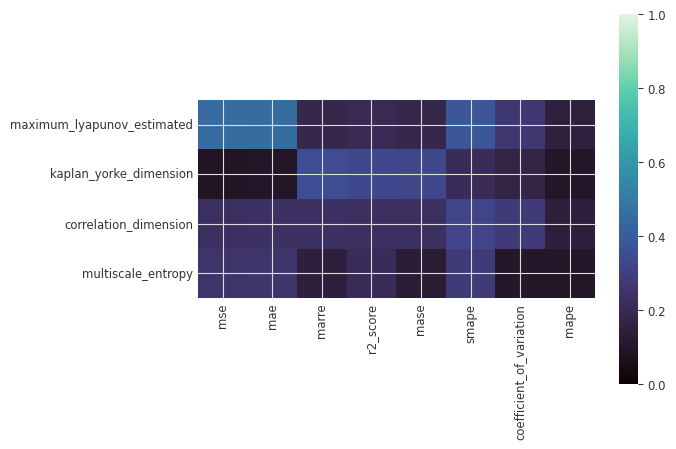

In [16]:
cross_corr = pd.concat([metrics_df, all_properties], axis=1, keys=['metrics_df', 'all_properties']).corr(method="spearman").loc['metrics_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_math.png", dpi=600)

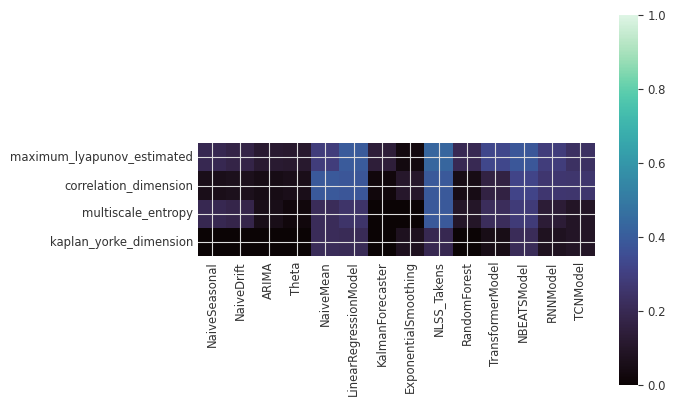

In [17]:
cross_corr = pd.concat([models_df, all_properties], axis=1, keys=['models_df', 'all_properties']).corr(method="spearman").loc['models_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds][df_models_sorted.columns], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/models_math_corr.png", dpi=600)

## figures from here 

In [18]:
df_models_sorted.columns

Index(['NaiveSeasonal', 'NaiveDrift', 'ARIMA', 'Theta', 'NaiveMean',
       'LinearRegressionModel', 'KalmanForecaster', 'ExponentialSmoothing',
       'NLSS_Takens', 'RandomForest', 'TransformerModel', 'NBEATSModel',
       'RNNModel', 'TCNModel'],
      dtype='object')

In [19]:
df_models_sorted.head()

,NaiveSeasonal,NaiveDrift,ARIMA,Theta,NaiveMean,LinearRegressionModel,KalmanForecaster,ExponentialSmoothing,NLSS_Takens,RandomForest,TransformerModel,NBEATSModel,RNNModel,TCNModel
0,164.043138,173.044327,163.682966,153.480297,190.711858,137.924133,195.530174,165.969501,108.995081,146.901161,126.114801,138.889482,123.982040,144.231482
1,134.434837,137.199161,122.864423,121.491827,193.116808,152.772693,178.212662,125.169808,133.661549,119.318160,137.130071,137.442555,155.156217,148.076252
2,65.443149,65.595894,75.212565,77.361207,71.464665,71.961412,106.107991,97.217847,54.296391,69.199848,66.838838,91.106016,70.681091,65.826341
3,143.699998,145.533416,144.081559,140.808916,187.979066,159.900688,152.992629,162.061235,128.755182,143.170330,142.294976,130.259152,143.059170,109.079700
4,6.526570,7.206717,7.273803,7.095917,7.276113,6.293718,7.064053,7.775495,6.579910,6.108549,5.983614,9.709348,13.690842,6.524502


In [20]:
df_models_sorted=df_models_sorted.rename(columns = {'NLSS_Takens':'PNL-SS', 'LinearRegressionModel': 'LinearRegression', 'ExponentialSmoothing' : 'ExpSmoothing', 'TransformerModel': 'Transformer', 'NBEATSModel' : 'NBEATS', 'RNNModel' : 'RNN', 'TCNModel': 'TCN' })

In [21]:
order_high=['PNL-SS', 'NBEATS', 'Transformer', 'TCN',
       'RNN', 'RandomForest', 'Theta', 'ARIMA', 'NaiveSeasonal',
       'NaiveDrift', 'LinearRegression', 'ExpSmoothing',
       'NaiveMean', 'KalmanForecaster']

In [22]:
df_models_sorted = df_models_sorted.reindex(columns=order_high)

In [23]:
df_models_sorted.head()

,PNL-SS,NBEATS,Transformer,TCN,RNN,RandomForest,Theta,ARIMA,NaiveSeasonal,NaiveDrift,LinearRegression,ExpSmoothing,NaiveMean,KalmanForecaster
0,108.995081,138.889482,126.114801,144.231482,123.982040,146.901161,153.480297,163.682966,164.043138,173.044327,137.924133,165.969501,190.711858,195.530174
1,133.661549,137.442555,137.130071,148.076252,155.156217,119.318160,121.491827,122.864423,134.434837,137.199161,152.772693,125.169808,193.116808,178.212662
2,54.296391,91.106016,66.838838,65.826341,70.681091,69.199848,77.361207,75.212565,65.443149,65.595894,71.961412,97.217847,71.464665,106.107991
3,128.755182,130.259152,142.294976,109.079700,143.059170,143.170330,140.808916,144.081559,143.699998,145.533416,159.900688,162.061235,187.979066,152.992629
4,6.579910,9.709348,5.983614,6.524502,13.690842,6.108549,7.095917,7.273803,6.526570,7.206717,6.293718,7.775495,7.276113,7.064053


In [24]:
df_models_sorted = df_models_sorted[df_models_sorted.columns[::-1]]

In [25]:
df_models_sorted.head()

,KalmanForecaster,NaiveMean,ExpSmoothing,LinearRegression,NaiveDrift,NaiveSeasonal,ARIMA,Theta,RandomForest,RNN,TCN,Transformer,NBEATS,PNL-SS
0,195.530174,190.711858,165.969501,137.924133,173.044327,164.043138,163.682966,153.480297,146.901161,123.982040,144.231482,126.114801,138.889482,108.995081
1,178.212662,193.116808,125.169808,152.772693,137.199161,134.434837,122.864423,121.491827,119.318160,155.156217,148.076252,137.130071,137.442555,133.661549
2,106.107991,71.464665,97.217847,71.961412,65.595894,65.443149,75.212565,77.361207,69.199848,70.681091,65.826341,66.838838,91.106016,54.296391
3,152.992629,187.979066,162.061235,159.900688,145.533416,143.699998,144.081559,140.808916,143.170330,143.059170,109.079700,142.294976,130.259152,128.755182
4,7.064053,7.276113,7.775495,6.293718,7.206717,6.526570,7.273803,7.095917,6.108549,13.690842,6.524502,5.983614,9.709348,6.579910


In [26]:
corr_matrix=df_models_sorted.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

In [27]:
corr_matrix

,KalmanForecaster,NaiveMean,ExpSmoothing,LinearRegression,NaiveDrift,NaiveSeasonal,ARIMA,Theta,RandomForest,RNN,TCN,Transformer,NBEATS,PNL-SS
KalmanForecaster,1.000000,0.409197,0.572554,0.540520,0.509362,0.545213,0.806331,0.831098,0.659437,0.566489,0.616279,0.614345,0.454518,0.508898
NaiveMean,0.409197,1.000000,0.295596,0.881953,0.405083,0.405346,0.380625,0.404384,0.430633,0.591186,0.589206,0.506283,0.594288,0.667048
ExpSmoothing,0.572554,0.295596,1.000000,0.303138,0.568898,0.576268,0.756272,0.769073,0.579358,0.419692,0.433546,0.525030,0.254383,0.283631
LinearRegression,0.540520,0.881953,0.303138,1.000000,0.439159,0.460659,0.448390,0.474055,0.505602,0.655941,0.659775,0.578780,0.682213,0.769050
NaiveDrift,0.509362,0.405083,0.568898,0.439159,1.000000,0.970564,0.680318,0.664582,0.682487,0.500670,0.523044,0.554969,0.456487,0.492492
NaiveSeasonal,0.545213,0.405346,0.576268,0.460659,0.970564,1.000000,0.717846,0.703895,0.686109,0.525219,0.534838,0.569876,0.453277,0.506981
ARIMA,0.806331,0.380625,0.756272,0.448390,0.680318,0.717846,1.000000,0.968910,0.745594,0.571089,0.600062,0.658636,0.392030,0.437288
Theta,0.831098,0.404384,0.769073,0.474055,0.664582,0.703895,0.968910,1.000000,0.738876,0.583232,0.592760,0.674522,0.407183,0.458450
RandomForest,0.659437,0.430633,0.579358,0.505602,0.682487,0.686109,0.745594,0.738876,1.000000,0.634688,0.656010,0.717823,0.535679,0.517184
RNN,0.566489,0.591186,0.419692,0.655941,0.500670,0.525219,0.571089,0.583232,0.634688,1.000000,0.695179,0.587524,0.547284,0.682321


In [28]:
row_names = {'NLSS_Takens':'PNL-SS', 'LinearRegressionModel': 'LinearRegression', 'ExponentialSmoothing' : 'ExpSmoothing', 'TransformerModel': 'Transformer', 'NBEATSModel' : 'NBEATS', 'RNNModel' : 'RNN', 'TCNModel': 'TCN'}
cross_corr = cross_corr.rename(index = row_names)

In [29]:
cross_corr

,maximum_lyapunov_estimated,kaplan_yorke_dimension,multiscale_entropy,correlation_dimension
ARIMA,0.118893,-0.050562,0.051179,0.043504
ExpSmoothing,0.031229,0.074130,-0.033586,0.104837
KalmanForecaster,0.139764,-0.059077,-0.121311,0.020336
LinearRegression,0.394425,0.204701,0.247676,0.378418
NBEATS,0.381222,0.209369,0.280592,0.319530
PNL-SS,0.431324,0.192406,0.387529,0.389771
NaiveDrift,0.168947,-0.017836,0.178363,0.063650
NaiveMean,0.288680,0.211767,0.211943,0.390381
NaiveSeasonal,0.194052,-0.014503,0.192372,0.055988
RNN,0.285618,0.077422,0.129163,0.261435


In [30]:
math_sort_inds

correlation_dimension         0
multiscale_entropy            3
kaplan_yorke_dimension        2
maximum_lyapunov_estimated    1
dtype: int64

In [31]:
cross_corr = cross_corr.reindex(df_models_sorted.columns)

In [32]:
cross_corr1=cross_corr.reindex(order_high)

In [33]:
cross_corr1=cross_corr1.iloc[::-1]

In [34]:
cross_corr.head()

,maximum_lyapunov_estimated,kaplan_yorke_dimension,multiscale_entropy,correlation_dimension
KalmanForecaster,0.139764,-0.059077,-0.121311,0.020336
NaiveMean,0.288680,0.211767,0.211943,0.390381
ExpSmoothing,0.031229,0.074130,-0.033586,0.104837
LinearRegression,0.394425,0.204701,0.247676,0.378418
NaiveDrift,0.168947,-0.017836,0.178363,0.063650


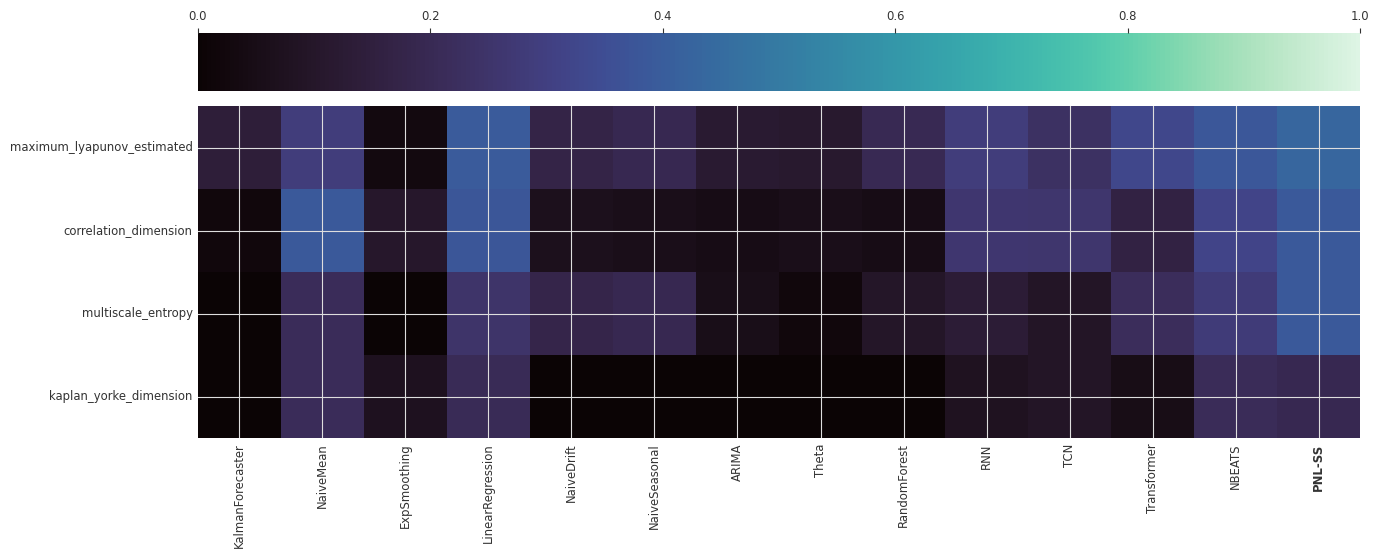

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cross_corr.transpose().iloc[math_sort_inds][df_models_sorted.columns], cmap="mako", vmin=0, vmax=1, cbar_kws={ "location": "top", "pad": 0.02000})
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)
plt.yticks(rotation=0)
ax.get_xticklabels()[13].set_weight('bold')
#fig.savefig('math_prop_cor.eps', format='eps', dpi=500)
#plt.savefig('math_prop_cor_PNL_SS.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.savefig('../fig/math_prop_cor_PNL_SS.jpg', format='jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [36]:
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]

In [37]:
sort_order = np.argsort(all_medians)

In [38]:
sort_order

array([ 5,  4, 13, 12,  0, 11,  9, 10,  6,  8,  1,  3,  7,  2])

In [39]:
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
sort_order1 = np.argsort(all_means)

In [40]:
sort_order1

array([ 5,  4, 13, 11,  9, 10, 12,  0,  8,  6,  3,  1,  7,  2])

## Group models by mathematical properties

In [41]:
equation_names = list(all_results.keys())
model_names = list(all_results[equation_names[0]].keys())
model_names.remove("values")
score_names = list(all_results[equation_names[0]][model_names[0]].keys())
score_names.remove("prediction")

results_reduced = dict()
for equation_name in equation_names:
    if equation_name in ['GenesioTesi','Hadley','SprottD','StickSlipOscillator']:
        continue
    results_reduced[equation_name] = dict()
    for model_name in model_names:
        val = all_results[equation_name][model_name]["smape"]
        results_reduced[equation_name][model_name] = val 
results_reduced = pd.DataFrame.from_dict(results_reduced)     
results_reduced = results_reduced.iloc[sort_order1] # sort by median error

In [42]:
results_reduced

,Aizawa,AnishchenkoAstakhov,Arneodo,ArnoldBeltramiChildress,ArnoldWeb,AtmosphericRegime,BeerRNN,BelousovZhabotinsky,BickleyJet,Blasius,...,Torus,Tsucs2,TurchinHanski,VallisElNino,VossDelay,WangSun,WindmiReduced,YuWang,YuWang2,ZhouChen
NLSS_Takens,108.995081,133.661549,54.296391,128.755182,6.579910,117.312971,77.400865,126.215683,19.705387,32.257335,...,2.862721,168.820544,85.611407,134.525452,161.024354,146.658011,17.414542,125.834991,94.668051,160.174799
NBEATSModel,138.889482,137.442555,91.106016,130.259152,9.709348,121.125756,57.647246,137.056820,34.997118,53.067522,...,5.121517,157.688987,95.194953,139.607074,124.749485,127.667863,22.335533,151.152708,90.302920,148.096771
TransformerModel,126.114801,137.130071,66.838838,142.294976,5.983614,113.038869,85.123851,117.244121,33.217915,41.249091,...,4.731611,178.504228,84.219849,111.492526,113.907125,151.991722,22.166444,126.931023,115.673008,164.601291
TCNModel,144.231482,148.076252,65.826341,109.079700,6.524502,146.615526,73.885741,123.669293,37.225374,39.786016,...,4.842575,133.293210,81.871357,112.383002,130.438096,140.989266,22.928603,124.336254,88.054393,175.082381
RNNModel,123.982040,155.156217,70.681091,143.059170,13.690842,180.659769,100.410303,127.048252,23.221301,54.618829,...,4.702433,137.642572,105.733003,135.089485,144.370435,142.951138,24.134280,156.047027,163.392745,138.022405
RandomForest,146.901161,119.318160,69.199848,143.170330,6.108549,163.612980,67.592970,153.993310,34.161426,40.262610,...,4.228697,153.638138,174.707907,153.386456,137.008721,141.938728,20.681690,126.382142,166.152085,135.529414
Theta,153.480297,121.491827,77.361207,140.808916,7.095917,184.026819,70.618423,131.373265,32.204570,39.772168,...,5.584424,148.320855,185.875628,111.219905,144.205518,153.861709,18.262338,126.669242,166.919423,142.522237
ARIMA,163.682966,122.864423,75.212565,144.081559,7.273803,186.898107,71.188989,129.177203,32.306936,39.718086,...,4.793896,139.877174,184.326955,115.346629,148.418623,150.501616,17.802466,125.953469,167.364642,144.648126
NaiveSeasonal,164.043138,134.434837,65.443149,143.699998,6.526570,158.309568,64.229960,197.684204,32.276360,42.555687,...,4.843325,141.096656,124.883223,177.081995,126.068802,157.831061,22.008221,130.264422,169.003258,105.972237
NaiveDrift,173.044327,137.199161,65.595894,145.533416,7.206717,158.390014,64.212383,182.536565,32.266684,42.195621,...,4.839136,149.375229,117.158594,187.106381,125.832175,159.543363,22.211011,130.831681,169.634411,106.685278


In [43]:
sort_inds = all_properties.sort_values(by="maximum_lyapunov_estimated").index

In [44]:
sort_inds

Index(['Torus', 'BickleyJet', 'ForcedFitzHughNagumo', 'ForcedBrusselator',
       'CoevolvingPredatorPrey', 'CellCycle', 'HastingsPowell', 'BeerRNN',
       'Bouali2', 'SprottI',
       ...
       'Chen', 'BurkeShaw', 'YuWang', 'QiChen', 'BlinkingVortex',
       'BlinkingRotlet', 'DoublePendulum', 'HyperQi', 'ExcitableCell',
       'BelousovZhabotinsky'],
      dtype='object', length=121)

In [45]:
color_list = sns.color_palette("husl", results_reduced.shape[0])

In [46]:
color_list[0] = "black"

In [47]:
color_list

['black',
 (0.9386807511529497, 0.48901639250529133, 0.19623149776413562),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.6566480096570136, 0.6229564921397143, 0.1938976562578914),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.19468252393000074, 0.6998280342882891, 0.3041476695746048),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.2266813382629933, 0.6508721810235698, 0.85618939194681),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.7563369715809057, 0.5008642633638004, 0.9580503362615219),
 (0.9587050080494409, 0.3662259565791742, 0.9231469575614251),
 (0.9640248692994725, 0.41206779951067346, 0.7303540600728443)]

In [48]:
row_names = {'NLSS_Takens':'PNL-SS', 'LinearRegressionModel': 'LinearRegression', 'ExponentialSmoothing' : 'ExpSmoothing', 'TransformerModel': 'Transformer', 'NBEATSModel' : 'NBEATS', 'RNNModel' : 'RNN', 'TCNModel': 'TCN'}
results_reduced = results_reduced.rename(index = row_names)

In [49]:
results_reduced

,Aizawa,AnishchenkoAstakhov,Arneodo,ArnoldBeltramiChildress,ArnoldWeb,AtmosphericRegime,BeerRNN,BelousovZhabotinsky,BickleyJet,Blasius,...,Torus,Tsucs2,TurchinHanski,VallisElNino,VossDelay,WangSun,WindmiReduced,YuWang,YuWang2,ZhouChen
PNL-SS,108.995081,133.661549,54.296391,128.755182,6.579910,117.312971,77.400865,126.215683,19.705387,32.257335,...,2.862721,168.820544,85.611407,134.525452,161.024354,146.658011,17.414542,125.834991,94.668051,160.174799
NBEATS,138.889482,137.442555,91.106016,130.259152,9.709348,121.125756,57.647246,137.056820,34.997118,53.067522,...,5.121517,157.688987,95.194953,139.607074,124.749485,127.667863,22.335533,151.152708,90.302920,148.096771
Transformer,126.114801,137.130071,66.838838,142.294976,5.983614,113.038869,85.123851,117.244121,33.217915,41.249091,...,4.731611,178.504228,84.219849,111.492526,113.907125,151.991722,22.166444,126.931023,115.673008,164.601291
TCN,144.231482,148.076252,65.826341,109.079700,6.524502,146.615526,73.885741,123.669293,37.225374,39.786016,...,4.842575,133.293210,81.871357,112.383002,130.438096,140.989266,22.928603,124.336254,88.054393,175.082381
RNN,123.982040,155.156217,70.681091,143.059170,13.690842,180.659769,100.410303,127.048252,23.221301,54.618829,...,4.702433,137.642572,105.733003,135.089485,144.370435,142.951138,24.134280,156.047027,163.392745,138.022405
RandomForest,146.901161,119.318160,69.199848,143.170330,6.108549,163.612980,67.592970,153.993310,34.161426,40.262610,...,4.228697,153.638138,174.707907,153.386456,137.008721,141.938728,20.681690,126.382142,166.152085,135.529414
Theta,153.480297,121.491827,77.361207,140.808916,7.095917,184.026819,70.618423,131.373265,32.204570,39.772168,...,5.584424,148.320855,185.875628,111.219905,144.205518,153.861709,18.262338,126.669242,166.919423,142.522237
ARIMA,163.682966,122.864423,75.212565,144.081559,7.273803,186.898107,71.188989,129.177203,32.306936,39.718086,...,4.793896,139.877174,184.326955,115.346629,148.418623,150.501616,17.802466,125.953469,167.364642,144.648126
NaiveSeasonal,164.043138,134.434837,65.443149,143.699998,6.526570,158.309568,64.229960,197.684204,32.276360,42.555687,...,4.843325,141.096656,124.883223,177.081995,126.068802,157.831061,22.008221,130.264422,169.003258,105.972237
NaiveDrift,173.044327,137.199161,65.595894,145.533416,7.206717,158.390014,64.212383,182.536565,32.266684,42.195621,...,4.839136,149.375229,117.158594,187.106381,125.832175,159.543363,22.211011,130.831681,169.634411,106.685278


In [50]:
#prop_name = "correlation_dimension"
prop_name = "maximum_lyapunov_estimated"
#prop_name = "multiscale_entropy"

all_vals = list()
vals = np.array(all_properties[prop_name])

all_windows = list(zip(10 * np.arange(9), 10 * np.arange(2, 11)))

for window in all_windows:
    sel_inds = all_properties[prop_name][
        all_properties[prop_name].between(
            np.percentile(vals, window[0]), np.percentile(vals, window[1])
        )
    ].index
    all_vals.append(results_reduced[sel_inds].median(axis=1))

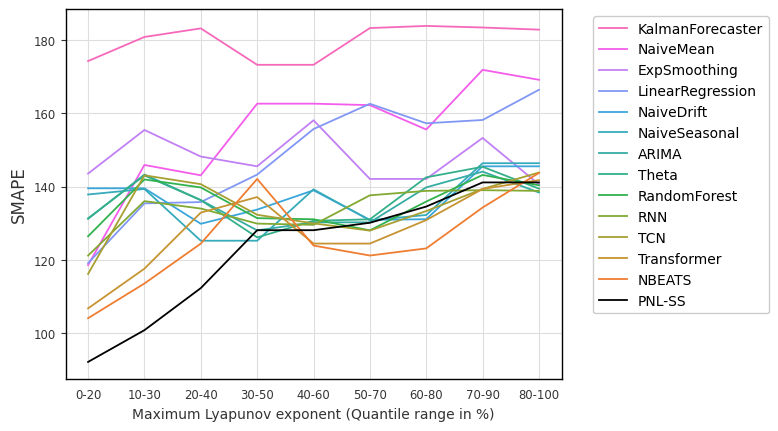

In [51]:
plt.figure()
for clr, row in reversed(list(zip(color_list, np.array(all_vals).T))):
    plt.plot(row, color=clr)
#plt.ylim([0, 180])

plt.legend(results_reduced.index[::-1], facecolor='white', framealpha=1, frameon=True, bbox_to_anchor=(1.05, 1))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gca().set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.gca().set_xticklabels(['0-20', '10-30', '20-40', '30-50', '40-60', '50-70', '60-80', '70-90', '80-100'])

plt.xlabel('Maximum Lyapunov exponent (Quantile range in %)', fontweight='normal')
plt.ylabel('SMAPE', fontweight='normal',fontsize=12)
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.grid(True)

#plt.savefig('line_plot_PNL_SS.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.savefig('../fig/line_plot_PNL_SS.jpg', format='jpg', dpi=1000, bbox_inches='tight')
plt.show()